[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)  
[2nd level. Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)  
[Porto Seguro Exploratory Analysis and Prediction](https://www.kaggle.com/code/gpreda/porto-seguro-exploratory-analysis-and-prediction)

# Introduction
Porto Seguro Auto  
  
This notebook starts by giving an introduction in the data of Porto Seguro competition. Then follows with preparing and running few predictive models using cross-validation and stacking and prepares a submission.  
  
The notebook is using elements from the following kernels:  
  
- [Data Preparation and Exploration](https://www.kaggle.com/code/bertcarremans/data-preparation-exploration) by Bert Carremans.
- [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/code/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails
- [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/code/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic
- [Simple Stacker](https://www.kaggle.com/code/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov
  
# DeepL번역
Porto Seguro Auto  
  
이 노트북은 포르투 세구로 대회의 데이터를 소개하는 것으로 시작합니다. 그런 다음 교차 검증과 스태킹을 사용하여 몇 가지 예측 모델을 준비하고 실행한 후 제출물을 준비합니다.  
  
노트북은 다음 커널의 요소를 사용하고 있습니다:  
  
- [데이터 준비 및 탐색](https://www.kaggle.com/code/bertcarremans/data-preparation-exploration) by Bert Carremans.
- [행운의 수레바퀴 - 포르투 세구로 EDA](https://www.kaggle.com/code/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails
- [인터랙티브 포르투 인사이트 - Plot.ly 튜토리얼](https://www.kaggle.com/code/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic
- [심플 스태커](https://www.kaggle.com/code/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov

# Analysis packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer    # 상기 클래스 변경
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

# Load the data

In [2]:
trainset = pd.read_csv('./input/002_porto-seguro-safe-driver-prediction/train.csv')
testset = pd.read_csv('./input/002_porto-seguro-safe-driver-prediction/test.csv')

# Few quick observations
We can make few observations based on the data description in the competition:  
  
- Few __groups__ are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The ind indicates most probably __individual, reg__ is probably __registration, car__ is self-explanatory, __calc__ suggests a __calculated__ field;
- The postfix __bin__ is used for binary features;
- The postfix __cat__ to is used for categorical features;
- Features without the __bin__ or __cat__ indications are real numbers (continous values) of integers (ordinal values);
- A missing value is indicated by __-1__;
- The value that is subject of prediction is in the __target__ column. This one indicates whether or not a claim was filed for that insured person;
- __id__ is a data input ordinal number.
  
Let's glimpse the data to see if these interpretations are confirmed.  
  
# DeepL 번역
대회에서 데이터 설명을 기반으로 몇 가지 관찰을 할 수 있습니다:
  
- 몇 개의 __그룹이__ 정의되어 있으며 이러한 그룹에 속하는 기능에는 이름에 패턴(ind, reg, car, calc)이 포함되어 있습니다. ind는 대부분 __individual__, __reg는__ __registration__, __car는__ 자명하며, __calc는__ __계산된__ 필드를 나타냅니다;
- 후위 __bin은__ 이진 기능에 사용됩니다;
- 후위 __cat은__ 범주형 피처에 사용됩니다;
- __bin__ 또는 __cat__ 표시가 없는 특징은 정수(서수 값)의 실수(연속형 값)입니다;
- 누락된 값은 __-1로__ 표시됩니다;
- 예측의 대상이 되는 값은 __target__ 열에 있습니다. 이 값은 해당 피보험자에 대한 보험금 청구가 접수되었는지 여부를 나타냅니다;
- __id는__ 데이터 입력 서수입니다.
  
이러한 해석이 맞는지 데이터를 통해 확인해 보겠습니다.

In [3]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


Indeed, we can observe the __cat__ values are __categorical__, integer values ranging from __0__ to __n__, bin values are __binary__ (either 0 or 1).  
  
Let's see how many rows and columns are in the data.

In [4]:
print('Train dataset (rows, cols):', trainset.shape, '\nTest dataset (rows, cols):', testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


There are 59 columns in the training dataset and only 58 in the testing dataset. Since from this dataset should have been extracted the __target__, this seems fine. Let's check the difference between the columns set in the two datasets, to make sure everything is fine.

In [5]:
print('Columns in train and not in test dataset:', set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


# Introduction of metadata
To make easier the manipulation of data, we will associate few meta-information to the variables in the trainset. This will facilitate the selection of various types of features for analysis, inspection or modeling. We are using as well a __category__ field for the `car`, `ind`, `reg` and `calc` types of features.  
  
What metadata will be used:  
  
- __use__: input, ID, target
- __type__: nominal, interval, ordinal, binary
- __preserve__: True or False
- __dataType__: int, float, char
- __category__: ind, reg, car, calc
  
# DeepL 번역
데이터를 더 쉽게 조작할 수 있도록 몇 가지 메타 정보를 훈련 세트의 변수에 연결할 것입니다. 이렇게 하면 분석, 검사 또는 모델링을 위한 다양한 유형의 기능을 쉽게 선택할 수 있습니다. 여기서는 `car`, `ind`, `reg` 및 `calc` 유형의 기능에 __category__ 필드도 사용합니다.  
  
사용될 메타데이터:  
  
- __use__: 입력, ID, 대상
- __type__: 명목, 간격, 서수, 바이너리
- __preserve__: 참 또는 거짓
- __dataType__: int, float, char
- __category__: ind, reg, car, calc

In [6]:
trainset['ps_ind_03'].dtype
# == int

dtype('int64')

In [7]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration (see references)
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'

    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    # elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):      # 버전탓?
    elif trainset[feature].dtype == 'float64' or isinstance(trainset[feature].dtype, float):
        type = 'real'
    # elif trainset[feature].dtype == int:      # 버전탓?
    elif trainset[feature].dtype == 'int64':
        type = 'integer'

    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type
    dtype = trainset[feature].dtype

    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'indvidual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'


    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)     # 해당 df의 설정만 지정
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,indvidual
ps_ind_02_cat,input,categorical,True,int64,indvidual
ps_ind_03,input,integer,True,int64,indvidual
ps_ind_04_cat,input,categorical,True,int64,indvidual
ps_ind_05_cat,input,categorical,True,int64,indvidual
ps_ind_06_bin,input,binary,True,int64,indvidual
ps_ind_07_bin,input,binary,True,int64,indvidual


In [8]:
# We can extract, for example, all categorical values:
metadata[(metadata.type=='categorical')&(metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [9]:
# Let's inspect all features, to see how many category distinct values do we have:

pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,indvidual,18
3,none,2
4,registration,3


In [10]:
# We have 20 calculated features, 16 car, 18 individual and 3 registration.
# Let's inspect now all features, to see how many use and type distinct values do we have:

pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


There are one nominal feature (the __id__), 20 binary values, 21 real (or float numbers), 16 categorical features - all these being as well __input__ values and one __target__ value, which is as well __binary__, the __target__.

# Data analysis and statistics

## Target varialbe

<Figure size 640x480 with 0 Axes>

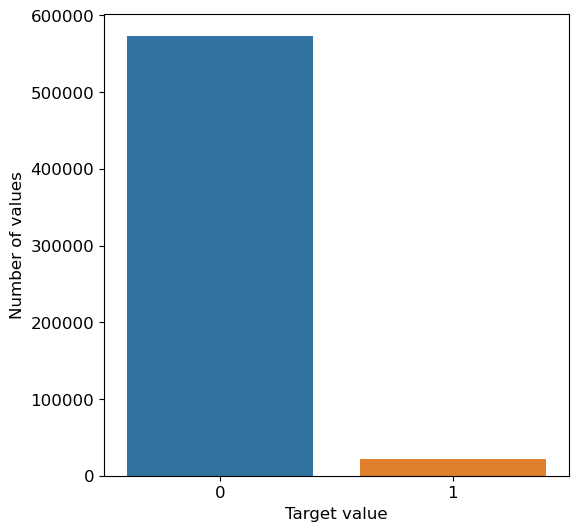

In [11]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

# Bar plot
# Order the bars dscending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Only 3.64% of the target data have 1 value. This means that the training dataset is highly imbalanced. We can either undersample the records with target = 0 or oversample records with target = 1; because is a large dataset, we will do undersampling of records with target = 0.  
  
## Real features

In [12]:
variable = metadata[(metadata.type=='real')&(metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [13]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [14]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

__Features with missing values__  
__ps_reg_o3__, __ps_car_12__, __ps_car_14__ have missing values (their minimum value is -1)  
  
__Registration features__
__ps_reg_01__ and __ps_reg_02__ are fractions with denominator 10 (values of 0.1, 0.2, 0.3 )  
  
__Car features__  
__ps_car_12__ are (with some approximations) square roots (divided by 10) of natural numbers whilst __ps_car_15__ are square roots of natural numbers. Let's represent the values using pairplot.

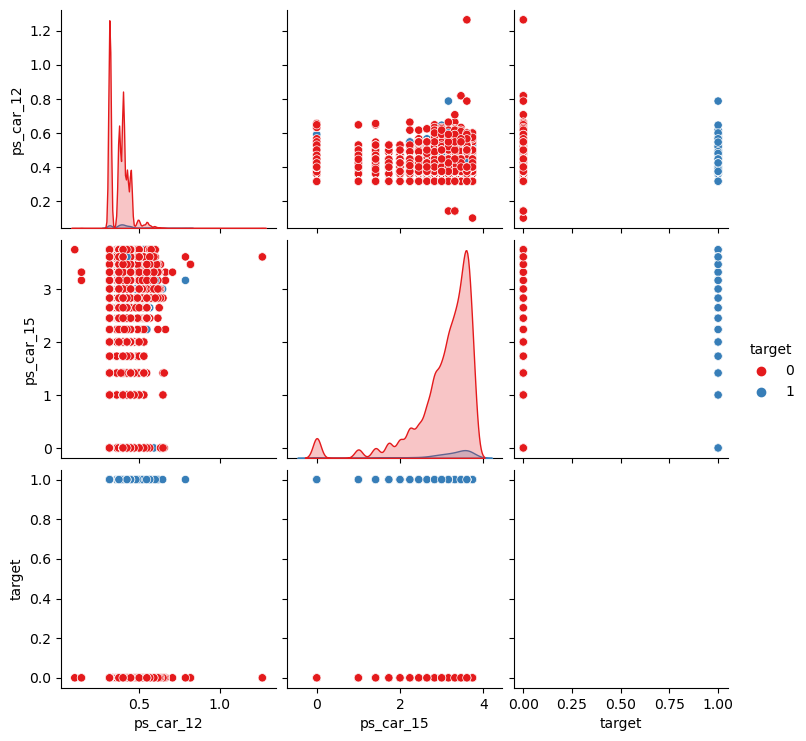

In [15]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde', 
             x_vars=var, y_vars=var)
plt.show()

__Calculated features__  
The features __ps_calc_01__, __ps_calc_02__ and __ps_calc_03__ have very similar distributions and could be some kind of ratio, since the maximum value is for all three 0.9. The other calculated values have maximum value an integer value (5, 6, 7, 10, 12).  
  
Let's visualize the real features distribution using density plot.

<Figure size 640x480 with 0 Axes>

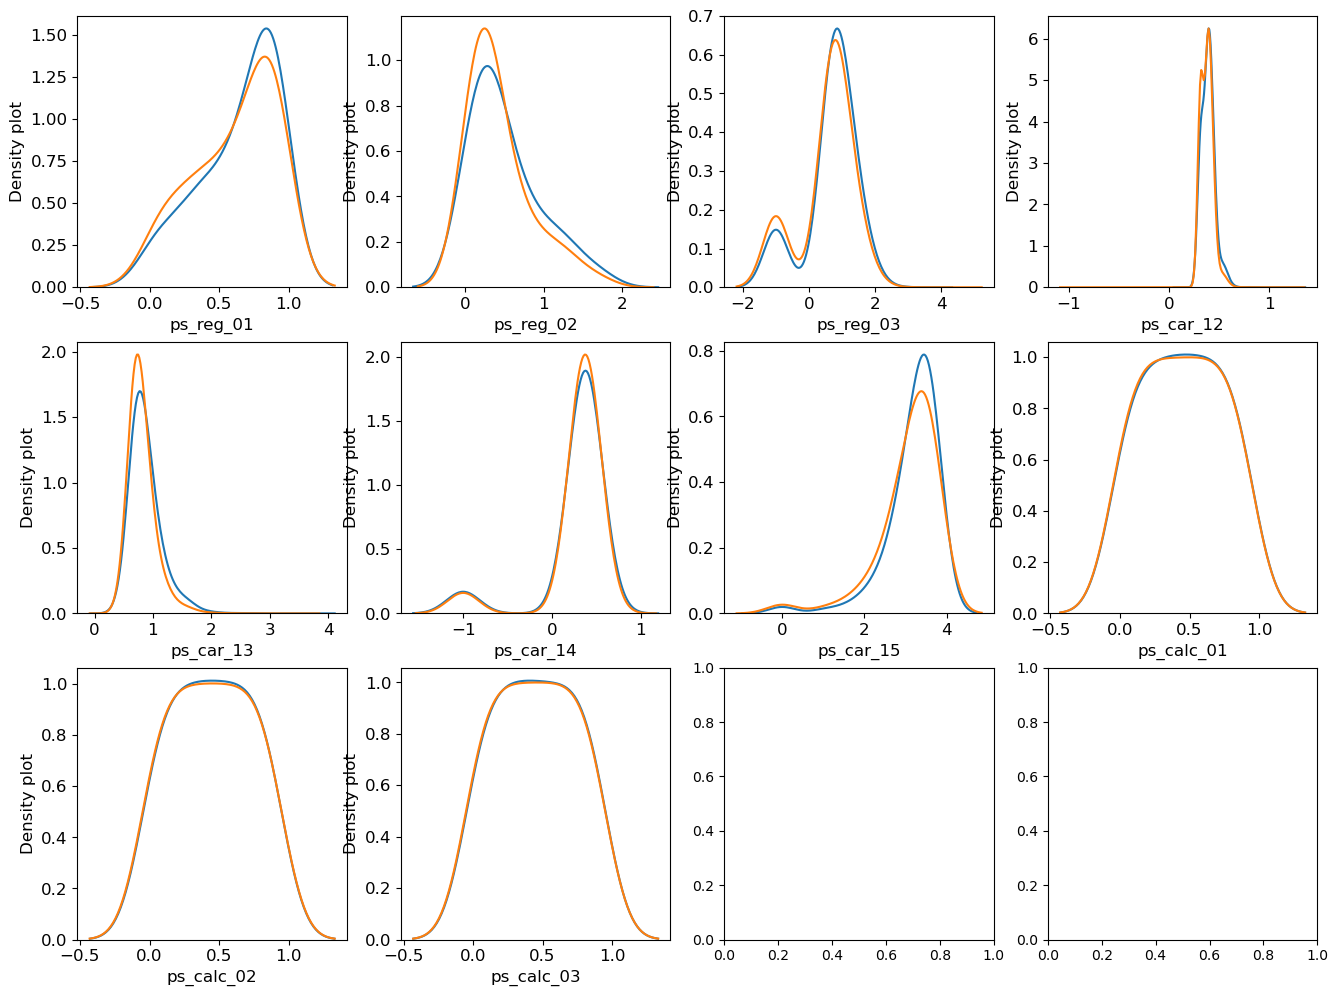

In [16]:
var = metadata[(metadata.type=='real')&(metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target']!=0]
t0 = trainset.loc[trainset['target']==0]

# sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label='target = 1')
    sns.kdeplot(t0[feature], bw=0.5, label='target = 0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

__ps_reg_02__, __ps_car_13__, __ps_car_15__ shows the most different distributions between sets of values associated with __target=0__ and __target=1__.  
  
Let's visualize the correlation between the real features

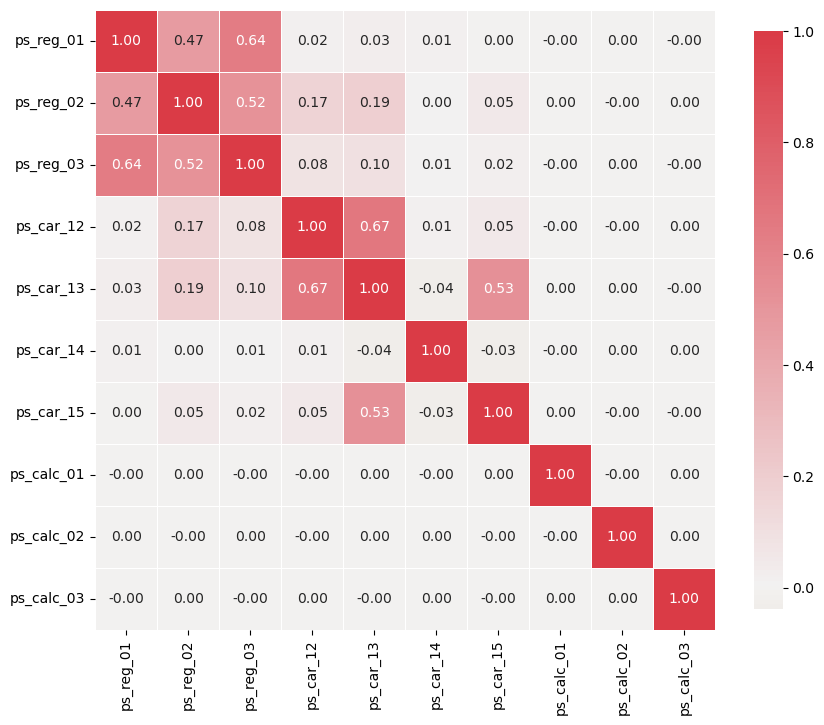

In [17]:
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=0.5, annot=True, cbar_kws={'shrink': 0.75})
    plt.show();

var = metadata[(metadata.type=='real')&(metadata.preserve)].index
corr_heatmap(var)

Let's visualize the plots of the variables with strong correlations. These are:  
  
- ps_reg_01 with ps_reg_02 (0.47);
- ps_reg_01 with ps_reg_03 (0.64);
- ps_reg_02 with ps_reg_03 (0.52);
- ps_car_12 with ps_car_13 (0.67);
- ps_car_13 with ps_car_15 (0.53);
  
To show the pairs of values that are correlated we use pairplot. Before representing the pairs, we subsample the data, using only 2% in the sample.

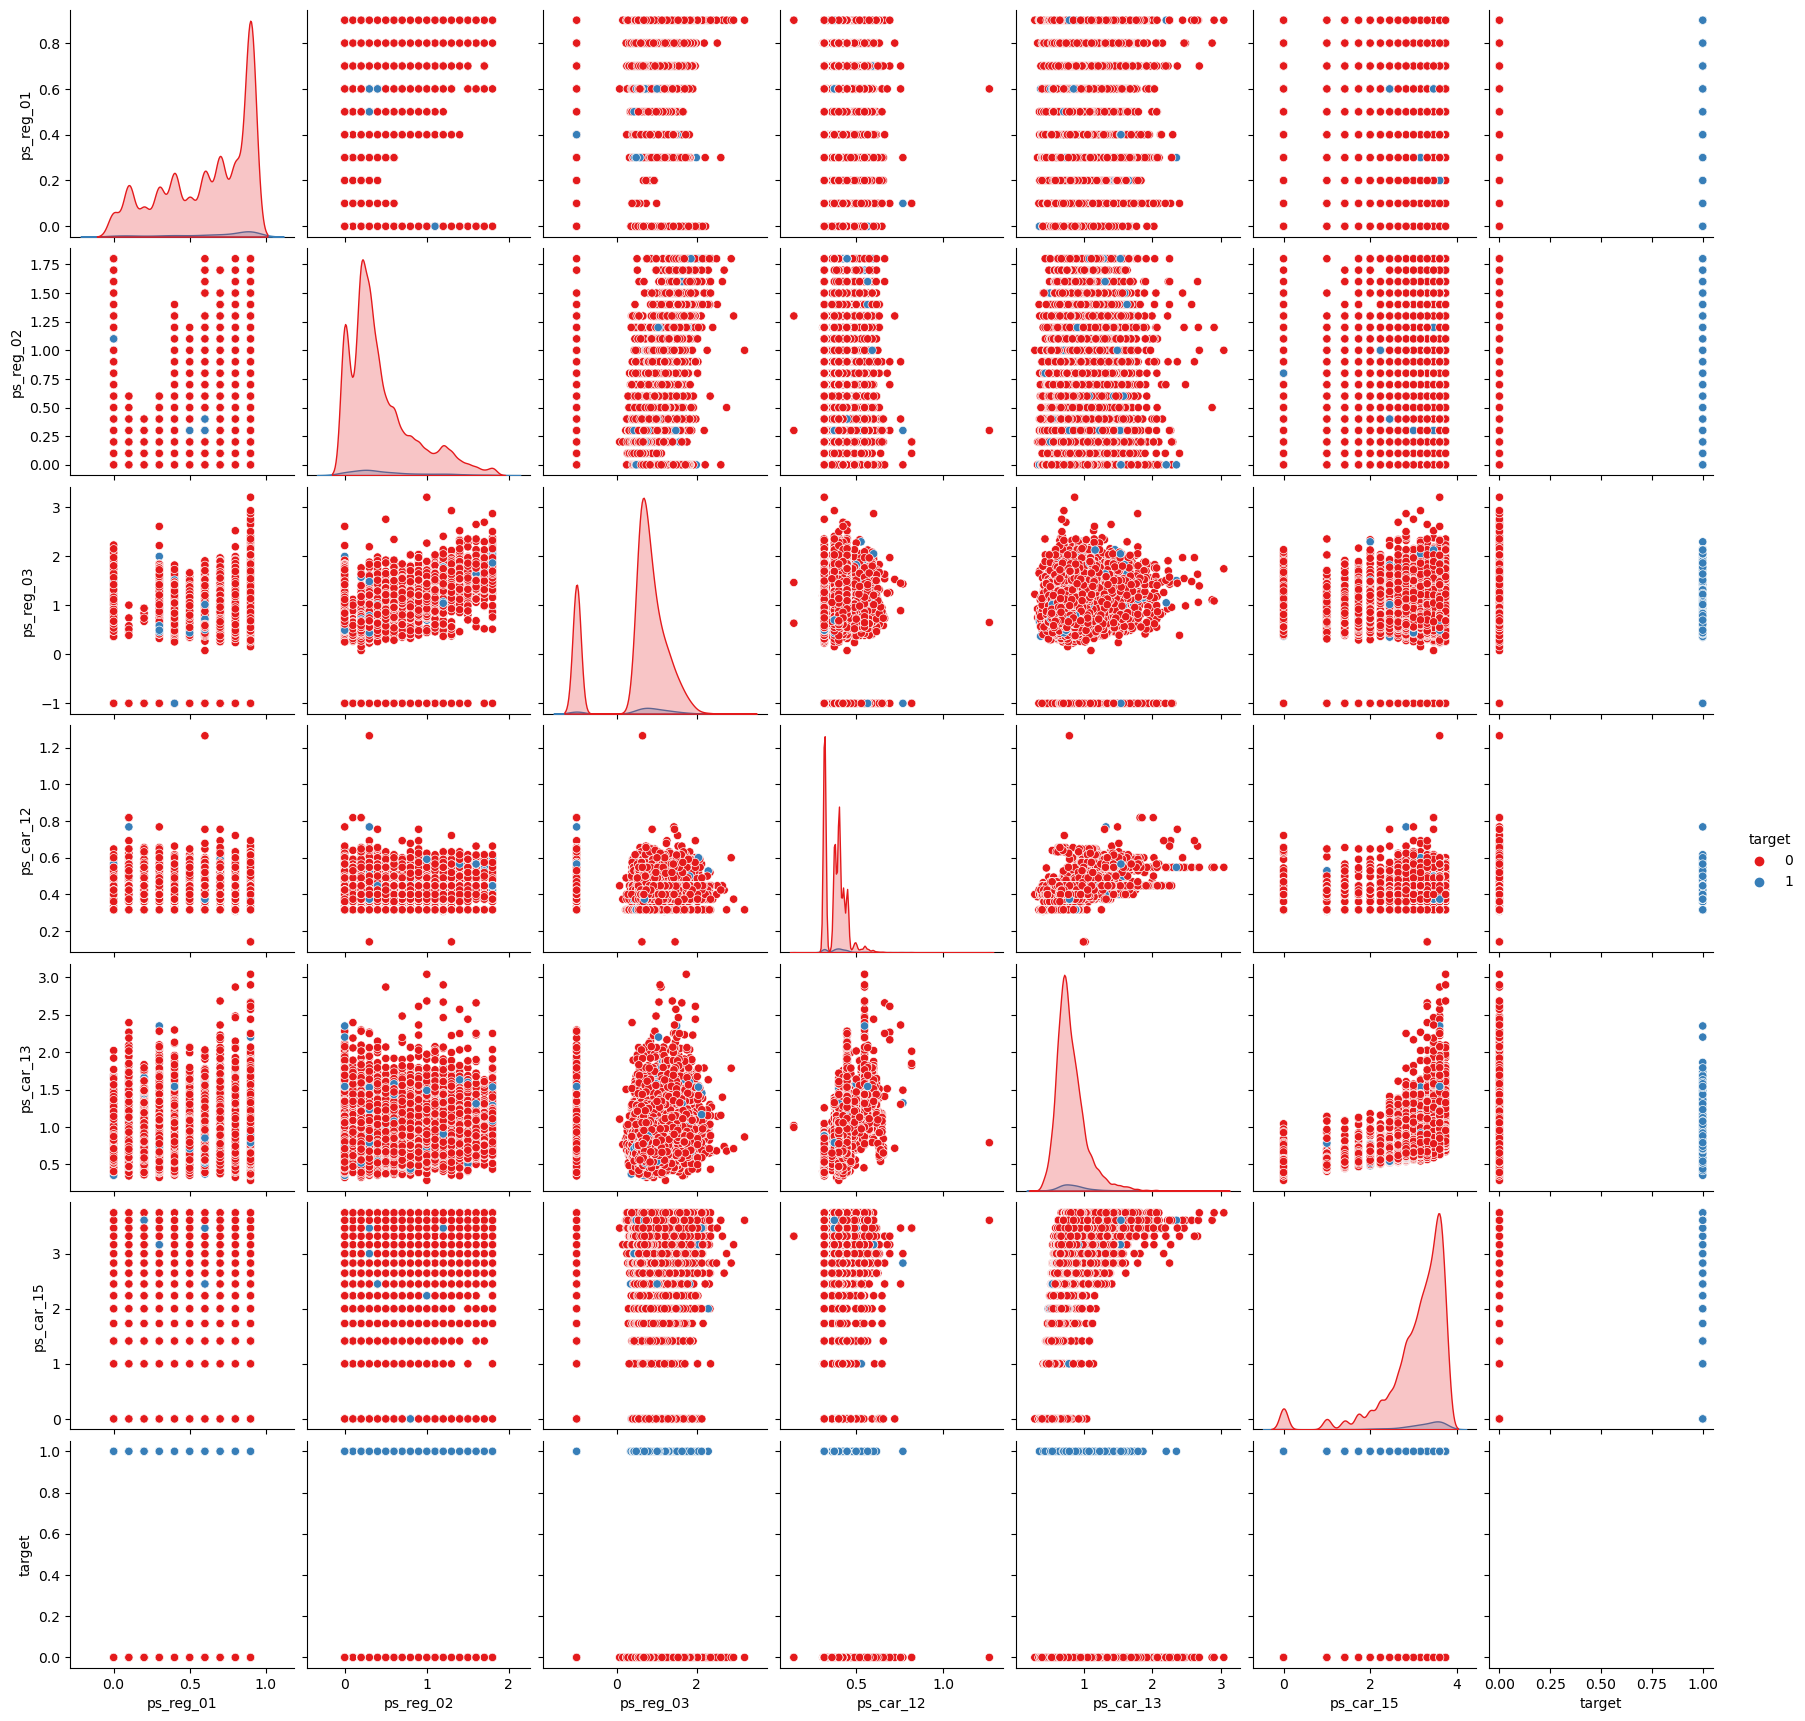

In [18]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde', x_vars=var, y_vars=var)
plt.show();

# Binary features

https://www.kaggle.com/code/gpreda/porto-seguro-exploratory-analysis-and-prediction